# Summary Evaluation Demo

This notebook demonstrates how to evaluate financial/business summaries using ROUGE, BERTScore, and stylometric analysis.

## Local RoBERTa Model Setup (Optional - Recommended)

For faster evaluation and offline usage, download RoBERTa-large model locally:

```bash
# Run once to download model files (~1.4GB) using proper cache structure
python setup_roberta_v2.py

# Verify it works
python test_local_roberta.py
```

The notebook will automatically detect and use local model files if available.

## Setup

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from src.io_utils import load_all_records
from src.content_metrics import ContentMetricsCalculator
from src.style_features import StyleAnalyzer
from rouge_score import rouge_scorer

print("✓ Imports successful")

✓ Imports successful


## Load Data

Load JSON files from data/ directory:

In [2]:
# Load all JSON files
records = load_all_records('data')

print(f"✓ Loaded {len(records)} records")
print(f"\nPersonas: {set(r['persona'] for r in records)}")
print(f"Sectors: {set(r['sector'] for r in records)}")

✓ Loaded 9 records

Personas: {'formal_analyst'}
Sectors: {'Economics', 'Automotive', 'Utilities', 'Tobacco', 'Technology', 'Semiconductors', 'Healthcare', 'Consumer Goods'}


## Examine One Example

In [3]:
# Look at first record
example = records[3]

print("📰 Title:", example['document_title'])
print("📝 Sector:", example['sector'])
print("👤 Author:", example['author'])
print("🎭 Persona (auto-detected):", example['persona'])
print("🤖 Model:", example['model_used'])
print("📋 Prompt:", example['prompt_type'])
print("\n" + "="*80)
print("\n📄 SOURCE (first 300 chars):")
print(example['document_content'][:300] + "...")
print("\n" + "="*80)
print("\n🎯 EXPECTED SUMMARY:")
print(example['expected_summary'][:500] + "..." if len(example['expected_summary']) > 500 else example['expected_summary'])
print("\n" + "="*80)
print("\n🤖 GENERATED SUMMARY:")
print(example['generated_summary'][:500] + "..." if len(example['generated_summary']) > 500 else example['generated_summary'])

📰 Title: NextEra Energy: Renewable capacity expansion accelerates with record backlog of 24 GW
📝 Sector: Utilities
👤 Author: Robert Kim, CFA, Utilities & Power Analyst
🎭 Persona (auto-detected): formal_analyst
🤖 Model: gpt-4o
📋 Prompt: Research Note


📄 SOURCE (first 300 chars):
NextEra Energy reported Q4 2024 results and provided 2025-2027 growth outlook, highlighting aggressive renewable energy expansion plans. Adjusted EPS reached $0.98, in line with guidance, bringing full-year 2024 EPS to $3.35, up 10% year-over-year. The company announced record renewable energy backl...


🎯 EXPECTED SUMMARY:
NextEra reported Q4 2024 adjusted EPS of $0.98, FY2024 EPS $3.35 (+10% YoY). Record renewable backlog of 24 GW (up from 18 GW YoY), representing $35B capex through 2027: solar 14 GW, wind 7 GW, storage 3 GW. NextEra Energy Resources signed 4.2 GW new PPAs in Q4, 40% with tech companies (Meta, Google, AWS) for data centers. Average PPA duration 15-20 years with inflation-linked pricing. FP&L 

## ROUGE Metrics

ROUGE measures n-gram overlap:
- **ROUGE-1**: Word overlap
- **ROUGE-2**: 2-word phrase overlap  
- **ROUGE-L**: Longest common subsequence

In [4]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)

reference = example['expected_summary']
generated = example['generated_summary']

scores = scorer.score(reference, generated)

print("📊 ROUGE Scores for Example 1:\n")
for metric_name, metric_scores in scores.items():
    print(f"{metric_name.upper()}:")
    print(f"  Precision: {metric_scores.precision:.4f}")
    print(f"  Recall:    {metric_scores.recall:.4f}")
    print(f"  F1:        {metric_scores.fmeasure:.4f}\n")

📊 ROUGE Scores for Example 1:

ROUGE1:
  Precision: 0.5848
  Recall:    0.8291
  F1:        0.6859

ROUGE2:
  Precision: 0.3274
  Recall:    0.4650
  F1:        0.3842

ROUGELSUM:
  Precision: 0.5223
  Recall:    0.7405
  F1:        0.6126



## BERTScore

BERTScore uses neural embeddings to measure semantic similarity:

## Local Model Setup

Configure environment to use local RoBERTa model if available:

In [5]:
import os
from pathlib import Path

# Check if local RoBERTa model cache exists
model_cache_dir = Path("model_cache")
roberta_legacy_dir = Path("roberta-large")

#if model_cache_dir.exists() and list(model_cache_dir.glob("**/config.json")):
#    # Use new model_cache directory (from setup_roberta_v2.py)
#    os.environ['TRANSFORMERS_CACHE'] = str(model_cache_dir.absolute())#
#    os.environ['HF_HOME'] = str(model_cache_dir.absolute())
#    print(f"✓ Using local RoBERTa model cache from: {model_cache_dir.absolute()}")
#    print("  This will speed up BERTScore evaluation and works offline.")
if roberta_legacy_dir.exists() and (roberta_legacy_dir / "config.json").exists():
    # Use legacy roberta-large directory (from old setup_roberta.py)
    os.environ['TRANSFORMERS_CACHE'] = str(roberta_legacy_dir.absolute())
    os.environ['HF_HOME'] = str(roberta_legacy_dir.parent.absolute())
    print(f"✓ Using local RoBERTa model from: {roberta_legacy_dir.absolute()}")
    print("  Note: For better compatibility, run 'python setup_roberta_v2.py'")
else:
    print("ℹ Local RoBERTa model cache not found")
    print("  BERTScore will download from HuggingFace on first use.")
    print("  To download locally: run 'python setup_roberta_v2.py'")
print()

✓ Using local RoBERTa model from: /Users/dimitermilushev/code/projects/rogue/roberta-large
  Note: For better compatibility, run 'python setup_roberta_v2.py'



In [6]:
try:
    import bert_score
    
    print("Calculating BERTScore (may take a minute on first run)...\n")
    
    P, R, F1 = bert_score.score(
        [example['generated_summary']], 
        [example['expected_summary']],
        model_type='roberta-large',
        lang='en',
        rescale_with_baseline=True,
        verbose=False
    )
    
    print(f"📊 BERTScore:")
    print(f"  Precision: {P.item():.4f}")
    print(f"  Recall:    {R.item():.4f}")
    print(f"  F1:        {F1.item():.4f}")
    
    print(f"\n💡 BERTScore F1 of {F1.item():.4f} indicates ", end="")
    if F1.item() > 0.9:
        print("excellent semantic similarity")
    elif F1.item() > 0.85:
        print("good semantic similarity")
    else:
        print("fair semantic similarity")
    
    bertscore_available = True
    
except Exception as e:
    print(f"⚠ BERTScore demo skipped: {e}")
    print("Install with: pip install bert-score")
    bertscore_available = False

Calculating BERTScore (may take a minute on first run)...

📊 BERTScore:
  Precision: 0.4470
  Recall:    0.6361
  F1:        0.5407

💡 BERTScore F1 of 0.5407 indicates fair semantic similarity


## Stylometric Analysis

Extract writing style features:

In [7]:
persona_config = {
    'personas': {
        'formal_analyst': 'data/personas/formal_analyst.txt',
        'journalist': 'data/personas/journalist.txt',
        'enthusiast': 'data/personas/enthusiast.txt'
    }
}
style_analyzer = StyleAnalyzer(persona_config)

# Extract features
features = style_analyzer.extract_stylometric_features(example['generated_summary'])

feature_names = [
    'Function word rate',
    'Avg sentence length (norm)',
    'Type-token ratio',
    'Comma rate',
    'Period rate',
    'Exclamation rate',
    'Question rate',
    'Pronoun rate',
    'FK grade (norm)',
    'Avg word length (norm)'
]

print("📐 Stylometric Features:\n")
for name, value in zip(feature_names, features):
    print(f"{name:30s}: {value:.4f}")

📐 Stylometric Features:

Function word rate            : 0.0717
Avg sentence length (norm)    : 0.4077
Type-token ratio              : 0.6528
Comma rate                    : 1.1740
Period rate                   : 1.3122
Exclamation rate              : 0.0000
Question rate                 : 0.0000
Pronoun rate                  : 0.0000
FK grade (norm)               : 0.6555
Avg word length (norm)        : 0.4709


## Persona Similarity

In [8]:
# Build persona centroids
print("Building persona centroids...\n")
centroids = style_analyzer.build_persona_centroids(force_rebuild=True)
print(f"✓ Built centroids for {len(centroids)} personas\n")

# Calculate similarity to each persona
print(f"Summary persona: {example['persona']}")
print(f"\n📊 Style Similarity to Each Persona:\n")

similarities = {}
for persona_id in centroids.keys():
    similarity = style_analyzer.calculate_style_similarity(example['generated_summary'], persona_id)
    similarities[persona_id] = similarity
    marker = "✓" if persona_id == example['persona'] else " "
    print(f"  {marker} {persona_id:20s}: {similarity:.4f}")

best_match = max(similarities, key=similarities.get)
print(f"\n🏆 Best match: {best_match}")
if best_match == example['persona']:
    print("✓ Correct!")
else:
    print(f"✗ Mismatch (expected {example['persona']})")

Building persona centroids...

✓ Built centroids for 3 personas

Summary persona: formal_analyst

📊 Style Similarity to Each Persona:

  ✓ formal_analyst      : 0.8411
    journalist          : 0.8290
    enthusiast          : 0.6849

🏆 Best match: formal_analyst
✓ Correct!


## Complete Evaluation

Run full evaluation on all records:

In [9]:
results = []

print(f"Evaluating {len(records)} records...\n")

content_config = {
    'use_rouge': True,
    'use_bertscore': bertscore_available,
    'bertscore_model': 'roberta-large',
    'use_bleurt': False
}

content_calc = ContentMetricsCalculator({'content': content_config})

# Re-use the style_analyzer from earlier (already has persona config)
# Or create a new one with same config
if 'style_analyzer' not in dir():
    persona_config = {
        'personas': {
            'formal_analyst': 'data/personas/formal_analyst.txt',
            'journalist': 'data/personas/journalist.txt',
            'enthusiast': 'data/personas/enthusiast.txt'
        }
    }
    style_analyzer = StyleAnalyzer(persona_config)

for i, rec in enumerate(records, 1):
    print(f"  [{i}/{len(records)}] {rec['document_title'][:50]}...")
    
    # Calculate content metrics
    content_metrics = content_calc.calculate_all_metrics(
        source_text=rec['document_content'],
        reference=rec['expected_summary'],
        hypothesis=rec['generated_summary']
    )
    
    # Calculate style similarity
    style_sim = style_analyzer.calculate_style_similarity(
        rec['generated_summary'], 
        rec['persona']
    )
    
    # Calculate overall quality (70% content + 30% style)
    content_quality = content_metrics.get('content_quality', 0.0)
    style_score = style_sim if style_sim is not None else 0.0
    overall_quality = (0.7 * content_quality) + (0.3 * style_score)
    
    results.append({
        'file': rec['_source_file'],
        'title': rec['document_title'][:40],
        'sector': rec['sector'],
        'persona': rec['persona'],
        'model': rec['model_used'],
        **content_metrics,
        'style_similarity': style_sim,
        'overall_quality': overall_quality
    })

df = pd.DataFrame(results)
print("\n✓ Evaluation complete!")

Evaluating 9 records...

  [1/9] Amazon Web Services: Q4 results show reacceleratin...
Loading BERTScore model from local directory: roberta-large
  [2/9] Federal Reserve November FOMC Decision: Policy rat...
  [3/9] JPMorgan Economic Outlook 2026: Soft landing scena...
  [4/9] NextEra Energy: Renewable capacity expansion accel...
  [5/9] NVIDIA Corporation: Q324 earnings beat driven by d...
  [6/9] Pfizer Inc: Pipeline update shows progress in onco...
  [7/9] Procter & Gamble: Premium positioning strategy dri...
  [8/9] RLX Technology: Q325 strong beat across lines driv...
  [9/9] Tesla Inc: Q4 2024 results show delivery growth bu...

✓ Evaluation complete!


## Results Summary

In [10]:
print("\n📊 EVALUATION RESULTS\n")
print("="*80)

# Display key columns
display_cols = ['title', 'persona', 'overall_quality', 'rouge1_f', 'rougeLsum_f']
if bertscore_available and 'bertscore_f1' in df.columns:
    display_cols.append('bertscore_f1')
display_cols.append('style_similarity')

print(df[display_cols].to_string(index=False))

print("\n" + "="*80)
print("\n📈 SUMMARY STATISTICS\n")

print("Overall Quality (70% content + 30% style):")
print(f"  Overall Quality:  {df['overall_quality'].mean():.4f} ± {df['overall_quality'].std():.4f}")
print(f"  Min: {df['overall_quality'].min():.4f}, Max: {df['overall_quality'].max():.4f}")

print(f"\nContent Quality:")
print(f"  Content Quality:  {df['content_quality'].mean():.4f} ± {df['content_quality'].std():.4f}")
print(f"  ROUGE-1 F1:       {df['rouge1_f'].mean():.4f} ± {df['rouge1_f'].std():.4f}")
print(f"  ROUGE-Lsum F1:    {df['rougeLsum_f'].mean():.4f} ± {df['rougeLsum_f'].std():.4f}")

if bertscore_available and 'bertscore_f1' in df.columns:
    print(f"  BERTScore F1:     {df['bertscore_f1'].mean():.4f} ± {df['bertscore_f1'].std():.4f}")

print(f"\nStyle Fidelity:")
print(f"  Style Similarity: {df['style_similarity'].mean():.4f} ± {df['style_similarity'].std():.4f}")

print(f"\nBy Persona:")
for persona in sorted(df['persona'].unique()):
    persona_df = df[df['persona'] == persona]
    print(f"  {persona:20s}: {len(persona_df)} items")
    print(f"    Overall:  {persona_df['overall_quality'].mean():.3f}")
    print(f"    Content:  {persona_df['content_quality'].mean():.3f}")
    print(f"    ROUGE-L:  {persona_df['rougeLsum_f'].mean():.3f}")
    print(f"    Style:    {persona_df['style_similarity'].mean():.3f}")

print(f"\nBy Sector:")
for sector in sorted(df['sector'].unique()):
    sector_df = df[df['sector'] == sector]
    print(f"  {sector:20s}: {len(sector_df)} items, overall={sector_df['overall_quality'].mean():.3f}")


📊 EVALUATION RESULTS

                                   title        persona  overall_quality  rouge1_f  rougeLsum_f  bertscore_f1  style_similarity
Amazon Web Services: Q4 results show rea formal_analyst         0.732103  0.727891     0.625850      0.982595          0.818401
Federal Reserve November FOMC Decision:  formal_analyst         0.709057  0.626506     0.559036      0.968178          0.814032
JPMorgan Economic Outlook 2026: Soft lan formal_analyst         0.743981  0.732877     0.623288      0.975511          0.865342
NextEra Energy: Renewable capacity expan formal_analyst         0.733720  0.685864     0.612565      0.975578          0.841102
NVIDIA Corporation: Q324 earnings beat d formal_analyst         0.697103  0.539683     0.463492      0.973056          0.859945
Pfizer Inc: Pipeline update shows progre formal_analyst         0.739259  0.709677     0.567742      0.980606          0.897880
Procter & Gamble: Premium positioning st formal_analyst         0.743316  0.74924

## Visualization

Plot the results:


✓ Saved visualization to outputs/evaluation_viz.png


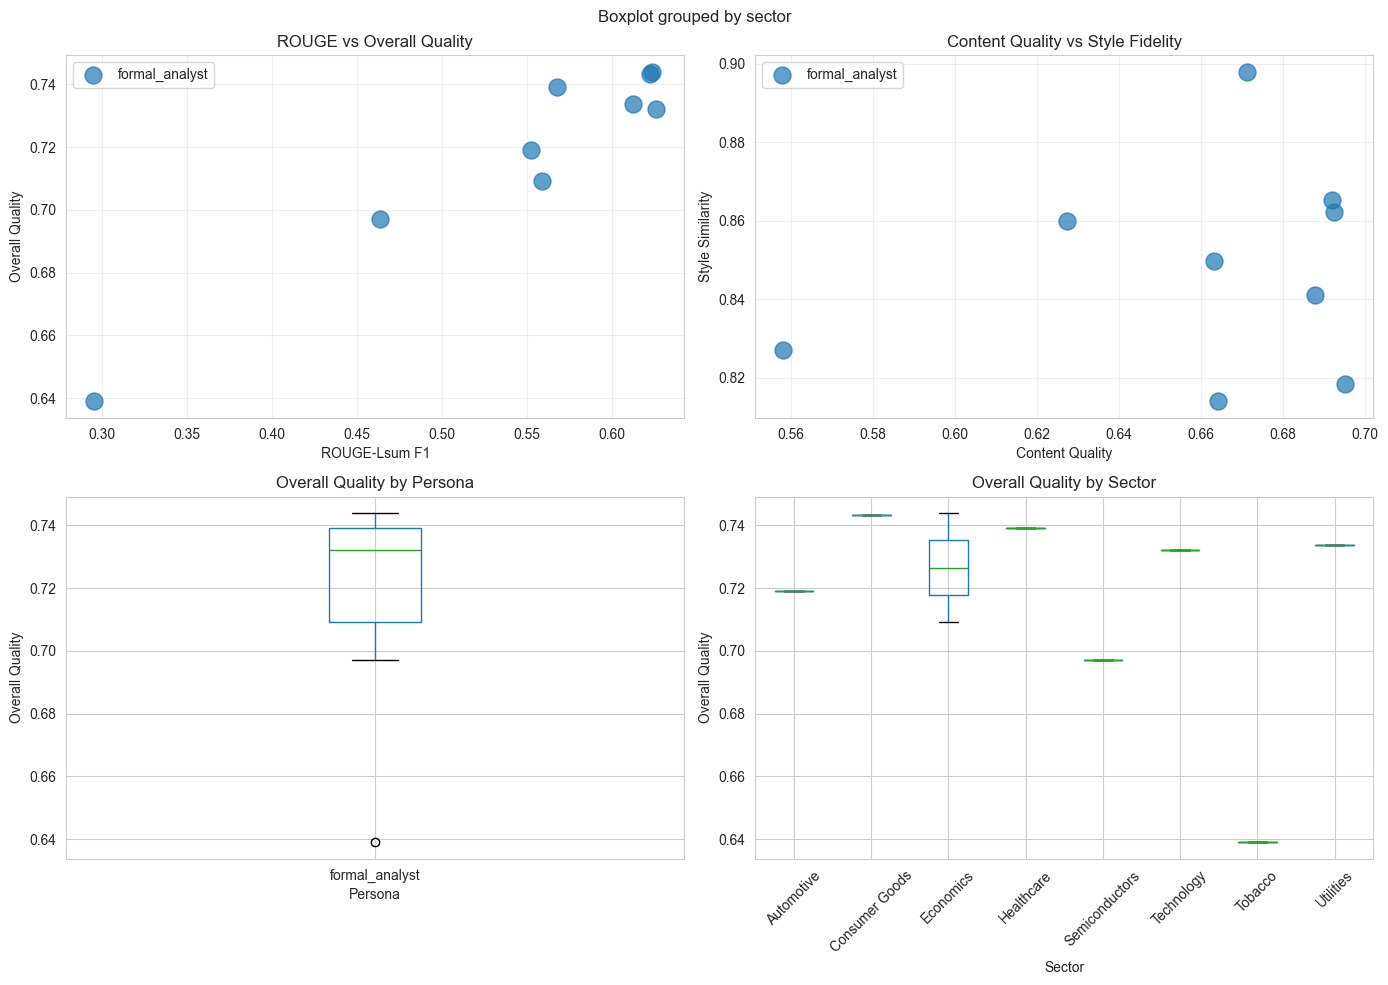

In [11]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Overall Quality vs ROUGE
    for persona in df['persona'].unique():
        persona_df = df[df['persona'] == persona]
        axes[0, 0].scatter(persona_df['rougeLsum_f'], persona_df['overall_quality'], 
                       label=persona, alpha=0.7, s=150)
    axes[0, 0].set_xlabel('ROUGE-Lsum F1')
    axes[0, 0].set_ylabel('Overall Quality')
    axes[0, 0].set_title('ROUGE vs Overall Quality')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Content vs Style
    for persona in df['persona'].unique():
        persona_df = df[df['persona'] == persona]
        axes[0, 1].scatter(persona_df['content_quality'], persona_df['style_similarity'], 
                       label=persona, alpha=0.7, s=150)
    axes[0, 1].set_xlabel('Content Quality')
    axes[0, 1].set_ylabel('Style Similarity')
    axes[0, 1].set_title('Content Quality vs Style Fidelity')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Overall quality by persona
    df.boxplot(column='overall_quality', by='persona', ax=axes[1, 0])
    axes[1, 0].set_title('Overall Quality by Persona')
    axes[1, 0].set_ylabel('Overall Quality')
    axes[1, 0].set_xlabel('Persona')
    
    # Overall quality by sector
    df.boxplot(column='overall_quality', by='sector', ax=axes[1, 1])
    axes[1, 1].set_title('Overall Quality by Sector')
    axes[1, 1].set_ylabel('Overall Quality')
    axes[1, 1].set_xlabel('Sector')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('outputs/evaluation_viz.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved visualization to outputs/evaluation_viz.png")
    plt.show()
    
except ImportError:
    print("⚠ Matplotlib not available")
    print("Install with: pip install matplotlib seaborn")

## Next Steps

1. **Add more JSON files** to `data/` directory
2. **Run full evaluation**: `python -m src.eval_runner`
3. **Check results**: `outputs/per_item_metrics.csv`
4. **Customize personas**: Edit `data/personas/*.txt`

### Interpreting Scores

**Overall Quality (Combined Metric):**
- Overall Quality > 0.6: Good summary (70% content + 30% style)
- Overall Quality > 0.7: Excellent summary

**Content Quality:**
- Content Quality > 0.6: Good content coverage (weighted ROUGE + BERTScore)
- ROUGE-Lsum F1 > 0.6: Good overlap with reference
- BERTScore F1 > 0.85: Strong semantic match

**Style Fidelity:**
- Style similarity > 0.7: Good persona match
- Style similarity > 0.8: Strong persona match

### Metric Weighting

The overall quality metric combines:
- **70% Content Quality**: Weighted average of ROUGE (40%), BERTScore (30%), BLEURT (30%)
- **30% Style Similarity**: Jensen-Shannon divergence of stylometric features